![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

seed=5489456

In [2]:
filename_features = "./Dados/UCI HAR Dataset/features.txt"
filename_labels   = "./Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "./Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain   = "./Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain   = "./Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest  = "./Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest   = "./Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest    = "./Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], squeeze=True, sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'], squeeze=True)
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'], squeeze=True)
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

# Utilizando dados padronizados

In [3]:
from sklearn.preprocessing import StandardScaler

# Criando um objeto scaler
scaler = StandardScaler()

# Aplicando a padronização nos dados de treino
X_train_pad = scaler.fit_transform(X_train)

# Aplicando a mesma padronização nos dados de teste
X_test_pad = scaler.transform(X_test)


In [4]:
%%time
prcomp = PCA().fit(X_train_pad) #não há variável resposta neste caso

pc_treino = prcomp.transform(X_train_pad)
pc_teste  = prcomp.transform(X_test_pad)
pc_treino.shape

CPU times: total: 1.39 s
Wall time: 278 ms


(7352, 561)

In [5]:
n=int(input("Número de variáveis para cálculo: "))
colunas = ['cp'+str(x+1) for x in list(range(n))]
pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head(5)

Número de variáveis para cálculo: 10


,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10
0,-16.138544,2.152024,3.144780,-0.272464,6.798938,-4.249394,2.937159,-4.905413,-0.775515,-3.627737
1,-15.296194,1.387144,-0.682221,2.813677,4.266170,-2.055663,0.011205,-1.845985,0.492546,-0.180175
2,-15.137019,2.473351,-1.756641,3.717974,4.181557,-1.357518,0.072947,-1.388188,0.539754,-0.671712
3,-15.350884,3.915681,-1.790322,2.567521,3.205840,-0.942944,0.530736,-1.832185,1.071517,-1.496989
4,-15.544814,4.598737,-2.188582,2.897578,3.080150,-1.061458,-1.048591,-0.816933,0.600063,1.118875


In [6]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0.001])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 3.61 s
Wall time: 3.61 s


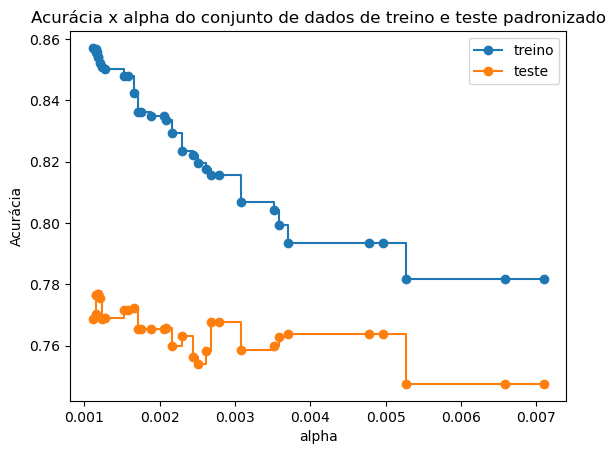

Acurácia da melhor árvore na base de treino:    85.4
Acurácia da melhor árvore na base de teste:     77.7


DecisionTreeClassifier(ccp_alpha=0.001186698213160759, random_state=2360873)

In [7]:
# Avaliação da acurácia do modelo
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste padronizado")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

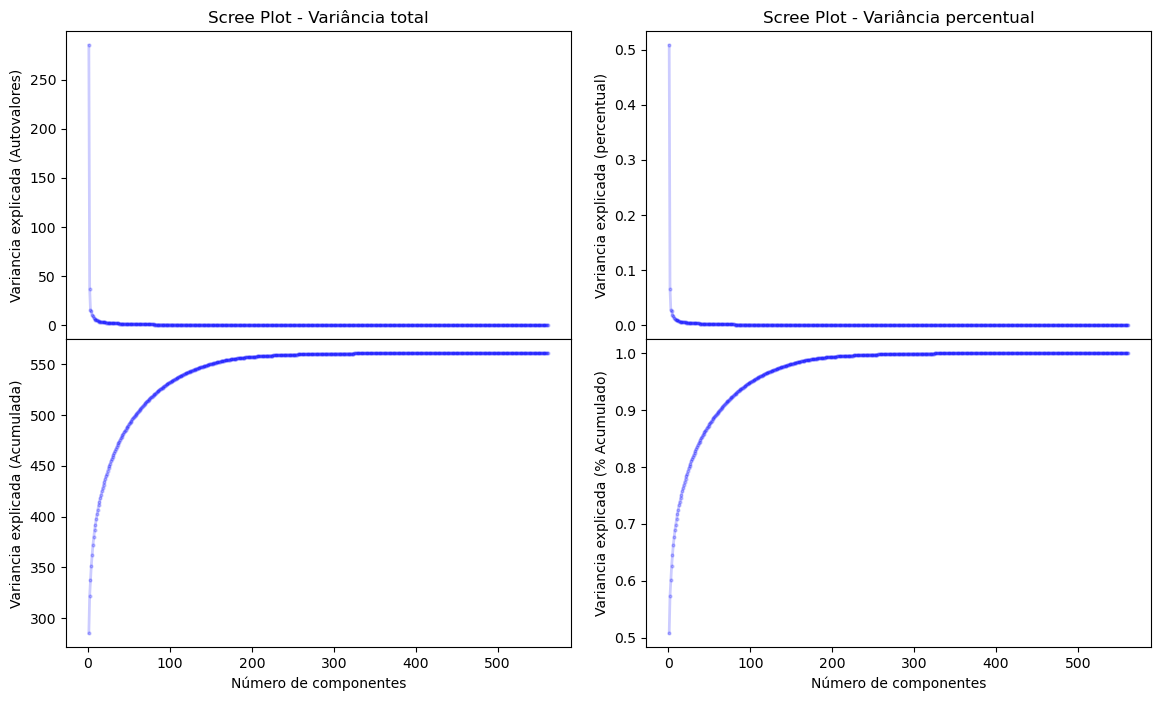

rank_ac,1º,2º,3º,4º,5º,6º,7º,8º,9º,10º,11º,12º,13º,14º,15º
variance,0.508,0.066,0.028,0.025,0.019,0.017,0.014,0.012,0.010,0.010,0.009,0.008,0.008,0.006,0.006
variance_ac,0.508,0.574,0.602,0.627,0.646,0.663,0.677,0.689,0.699,0.709,0.718,0.726,0.734,0.740,0.746


In [8]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

ampli_y1 = prcomp.explained_variance_[0]

num_componentes = np.arange(prcomp.n_components_) + 1

ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


ampli_y2 = prcomp.explained_variance_ratio_[0]
# ax[1].set_ylim(-ampli_y2*.05, ampli_y2*1.1)

ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')


plt.show()


#dataframe da taxa de variância
ratio = np.round(prcomp.explained_variance_ratio_,3)
variance_ratio = pd.DataFrame({'variance': ratio})
variance_ratio_cumsum = pd.DataFrame({'variance_ac': ratio.cumsum()})
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['variance_ac'].rank(method='min',ascending=True).astype(int)
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['rank_ac'].astype(str) + 'º'
variance_ratios_concat = pd.concat([variance_ratio, variance_ratio_cumsum], axis=1)
variance_ratios_concat[0:n+5].set_index('rank_ac').T


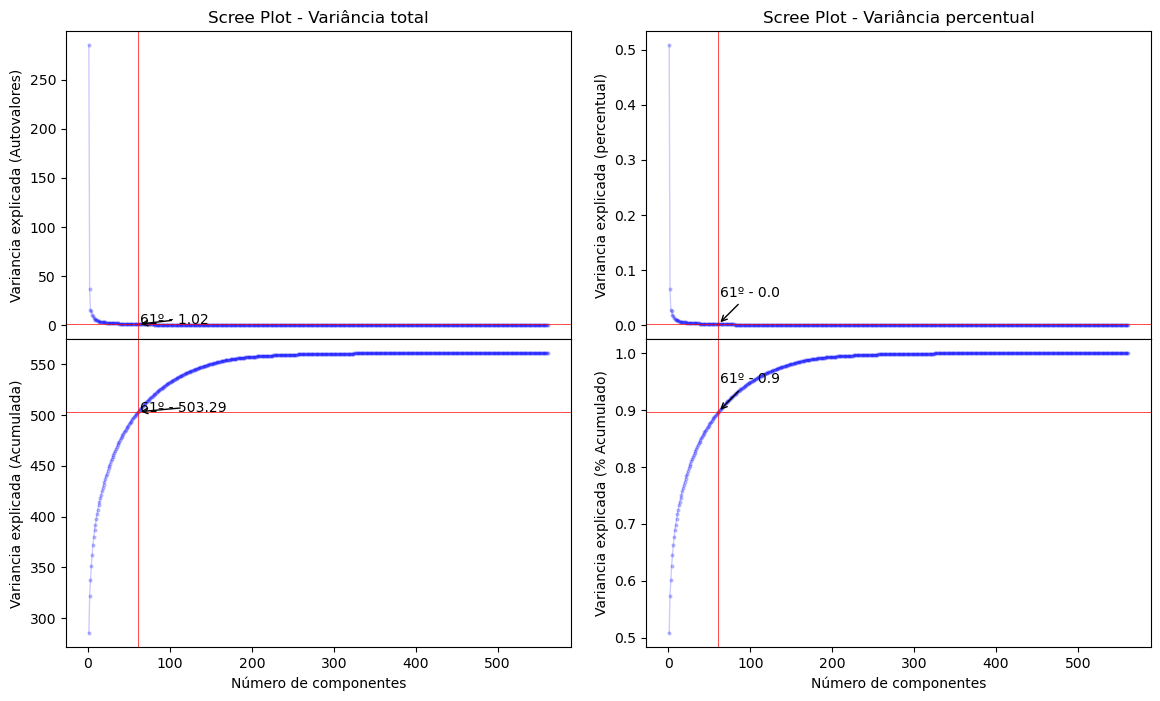

In [9]:
# Critério 1: autovalor padronizado > 1
ncomp_criterio1 = (prcomp.explained_variance_ratio_>1/prcomp.n_components_).sum()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')


#Gráfico da variância nominal acumulada por qtd_componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


# Gráfico da variância percentual por qtd_componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')


# Gráfico da variância percentual acumulada por qtd_componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)



# linhas horizontais
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)


# Adicionando o valor da intersecção nos gráficos
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], 2)}'
ax[1,1].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_.cumsum()[ncomp_criterio1-1], 2)}'
ax[1,0].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_.cumsum()[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_.cumsum()[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_ratio_[ncomp_criterio1-1], 2)}'
ax[0,1].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_ratio_[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_ratio_[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_[ncomp_criterio1-1], 2)}'
ax[0,0].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)

plt.show()




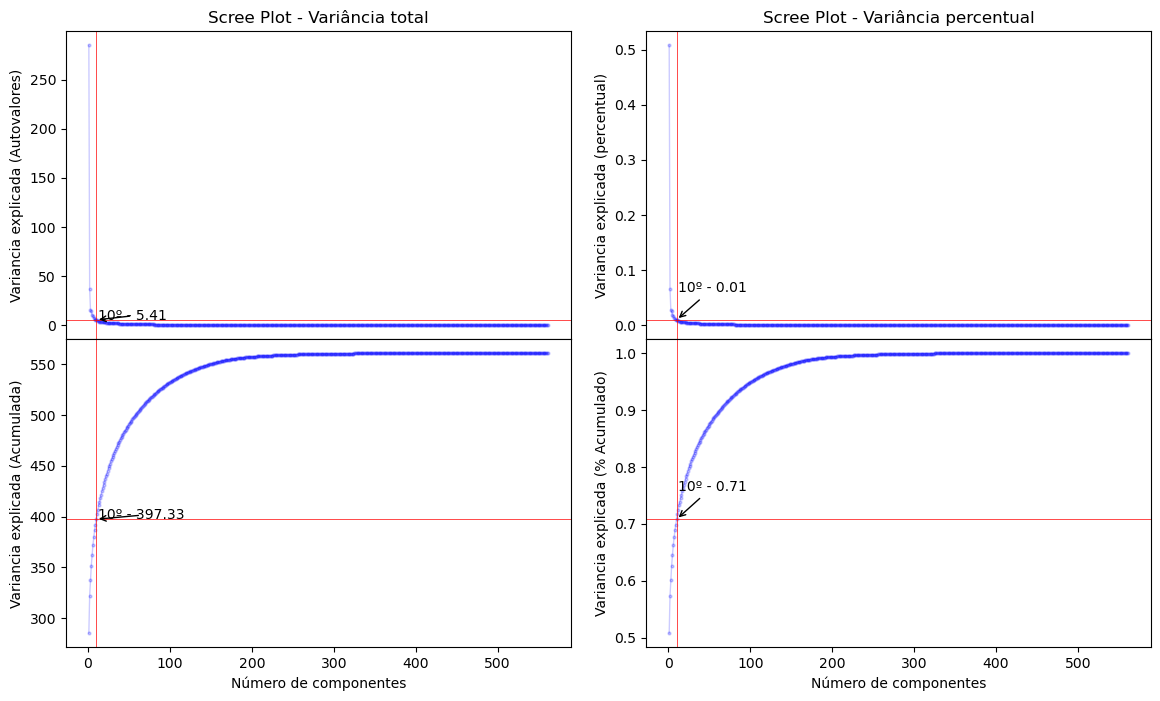

In [10]:
# Critério 2: Método do "cotovelo"
ncomp_criterio2 = n

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Número de componentes pelo critério 2
ax[0,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)

# Adicionando o valor da intersecção nos gráficos
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], 2)}'
ax[1,1].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_.cumsum()[ncomp_criterio2-1], 2)}'
ax[1,0].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_.cumsum()[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_.cumsum()[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_ratio_[ncomp_criterio2-1], 2)}'
ax[0,1].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_ratio_[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_ratio_[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_[ncomp_criterio2-1], 2)}'
ax[0,0].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)

plt.show()



Percentual desejado para explicação da variável: 90


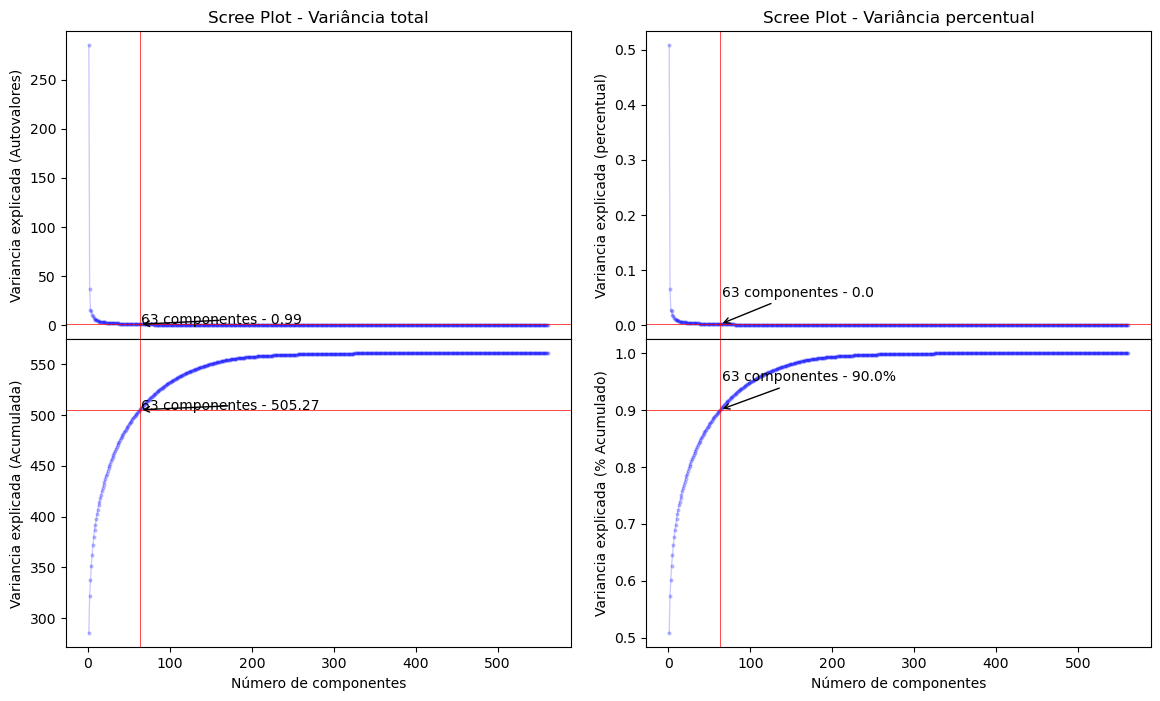

rank_ac,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
variance,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
variance_ac,0.883,0.885,0.887,0.889,0.891,0.893,0.895,0.897,0.899,0.901,0.903,0.905,0.907,0.909,0.911


In [11]:
# Critério 3: % variância explicada
n2=int(input('Percentual desejado para explicação da variável: '))
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = n2/100
ncomp_criterio3 = (prcomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)

# Adicionando o valor da intersecção nos gráficos
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], 2)*100}%'
ax[1,1].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_.cumsum()[ncomp_criterio3-1], 2)}'
ax[1,0].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_.cumsum()[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_.cumsum()[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_ratio_[ncomp_criterio3-1], 2)}'
ax[0,1].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_ratio_[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_ratio_[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_[ncomp_criterio3-1], 2)}'
ax[0,0].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)

plt.show()

ratio = np.round(prcomp.explained_variance_ratio_,3)
variance_ratio = pd.DataFrame({'variance': ratio})
variance_ratio_cumsum = pd.DataFrame({'variance_ac': ratio.cumsum()})
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['variance_ac'].rank(method='min',ascending=True).astype(int)
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['rank_ac'].astype(str) 
variance_ratios_concat = pd.concat([variance_ratio, variance_ratio_cumsum], axis=1)
variance_ratios_concat[(ncomp_criterio3-10):(ncomp_criterio3+5)].set_index('rank_ac').T

# Utilizando dados SEM padronização

In [12]:
%%time
prcomp = PCA().fit(X_train) #não há variável resposta neste caso

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)
pc_treino.shape


CPU times: total: 1.48 s
Wall time: 318 ms


(7352, 561)

In [13]:
n=int(input("Número de variáveis para cálculo: "))
colunas = ['cp'+str(x+1) for x in list(range(n))]
pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_test  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head(5)

Número de variáveis para cálculo: 10


,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206


In [14]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0.001])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 3.34 s
Wall time: 3.35 s


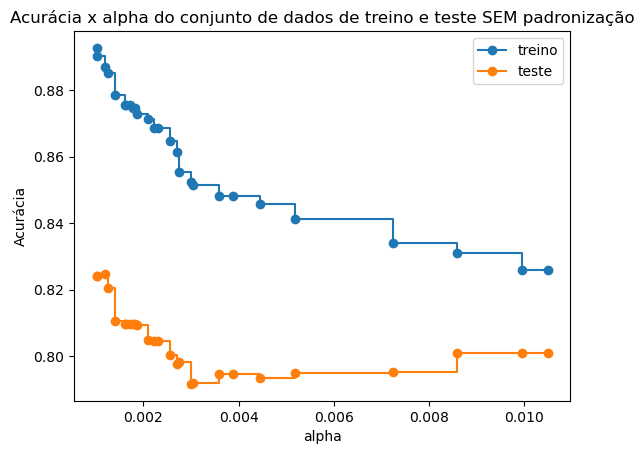

Acurácia da melhor árvore na base de treino:    88.7
Acurácia da melhor árvore na base de teste:     82.5


DecisionTreeClassifier(ccp_alpha=0.0011917390151356944, random_state=2360873)

In [15]:
# Avaliação da acurácia do modelo
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste SEM padronização")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

ind_melhor_arvore = len(test_scores) - test_scores[::-1].index(max(test_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_test, y_test)*100:.1f}')

melhor_arvore

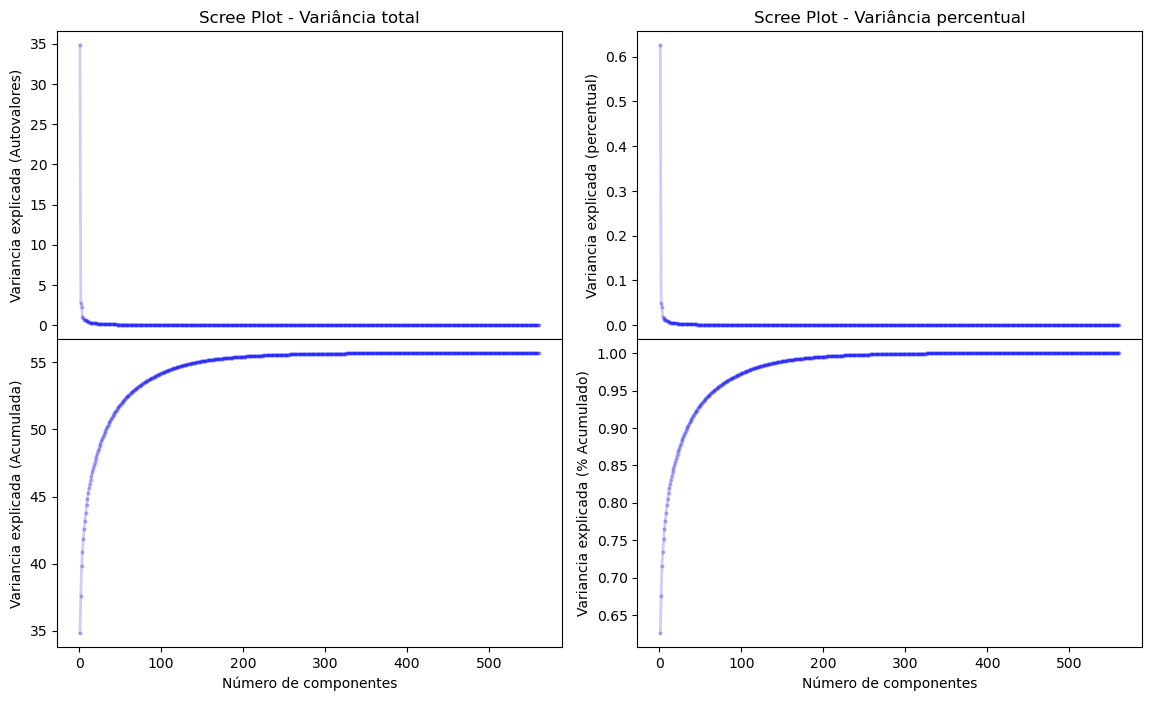

rank_ac,1º,2º,3º,4º,5º,6º,7º,8º,9º,10º,11º,12º,13º,14º,15º
variance,0.626,0.049,0.041,0.019,0.017,0.013,0.012,0.011,0.010,0.009,0.008,0.007,0.006,0.006,0.005
variance_ac,0.626,0.675,0.716,0.735,0.752,0.765,0.777,0.788,0.798,0.807,0.815,0.822,0.828,0.834,0.839


In [16]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

ampli_y1 = prcomp.explained_variance_[0]

num_componentes = np.arange(prcomp.n_components_) + 1

ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


ampli_y2 = prcomp.explained_variance_ratio_[0]
# ax[1].set_ylim(-ampli_y2*.05, ampli_y2*1.1)

ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')


plt.show()


#dataframe da taxa de variância
ratio = np.round(prcomp.explained_variance_ratio_,3)
variance_ratio = pd.DataFrame({'variance': ratio})
variance_ratio_cumsum = pd.DataFrame({'variance_ac': ratio.cumsum()})
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['variance_ac'].rank(method='min',ascending=True).astype(int)
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['rank_ac'].astype(str) + 'º'
variance_ratios_concat = pd.concat([variance_ratio, variance_ratio_cumsum], axis=1)
variance_ratios_concat[0:n+5].set_index('rank_ac').T


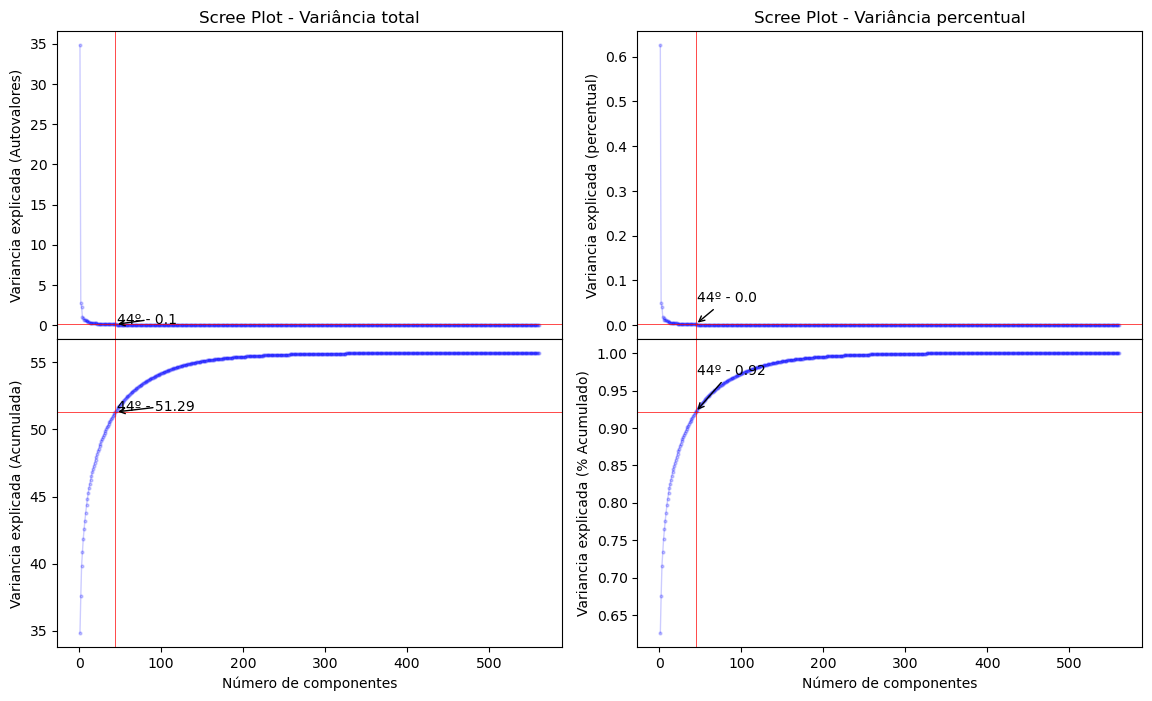

In [17]:
# Critério 1: autovalor padronizado > 1
ncomp_criterio1 = (prcomp.explained_variance_ratio_>1/prcomp.n_components_).sum()

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')


#Gráfico da variância nominal acumulada por qtd_componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')


# Gráfico da variância percentual por qtd_componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')


# Gráfico da variância percentual acumulada por qtd_componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio1, color = 'r', linestyle = '-', linewidth=.5)



# linhas horizontais
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], color = 'r', linestyle = '-', linewidth=.5)


# Adicionando o valor da intersecção nos gráficos
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1], 2)}'
ax[1,1].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_.cumsum()[ncomp_criterio1-1], 2)}'
ax[1,0].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_.cumsum()[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_.cumsum()[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_ratio_[ncomp_criterio1-1], 2)}'
ax[0,1].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_ratio_[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_ratio_[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio1}º - {np.round(prcomp.explained_variance_[ncomp_criterio1-1], 2)}'
ax[0,0].annotate(text, xy=(ncomp_criterio1, prcomp.explained_variance_[ncomp_criterio1-1]), xytext=(ncomp_criterio1+2, prcomp.explained_variance_[ncomp_criterio1-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)

plt.show()




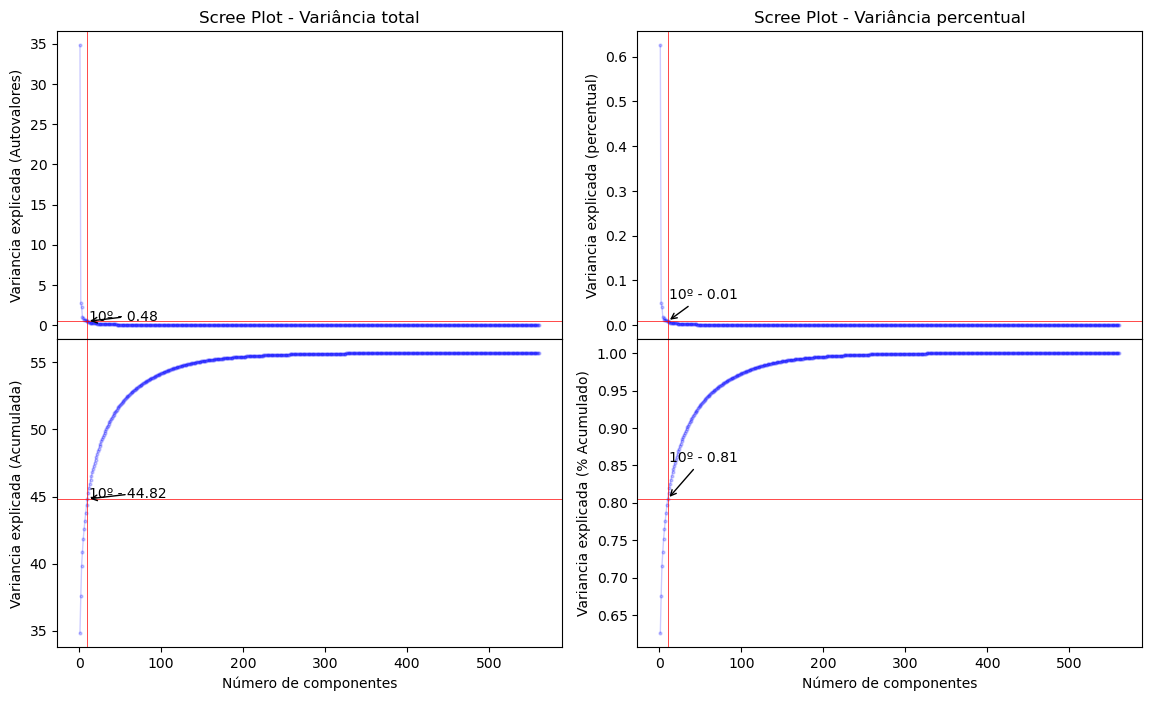

In [18]:
# Critério 2: Método do "cotovelo"
ncomp_criterio2 = n

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# Número de componentes pelo critério 2
ax[0,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio2, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], color = 'r', linestyle = '-', linewidth=.5)

# Adicionando o valor da intersecção nos gráficos
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1], 2)}'
ax[1,1].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_.cumsum()[ncomp_criterio2-1], 2)}'
ax[1,0].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_.cumsum()[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_.cumsum()[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_ratio_[ncomp_criterio2-1], 2)}'
ax[0,1].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_ratio_[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_ratio_[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio2}º - {np.round(prcomp.explained_variance_[ncomp_criterio2-1], 2)}'
ax[0,0].annotate(text, xy=(ncomp_criterio2, prcomp.explained_variance_[ncomp_criterio2-1]), xytext=(ncomp_criterio2+2, prcomp.explained_variance_[ncomp_criterio2-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)

plt.show()



Percentual desejado para explicação da variável: 90


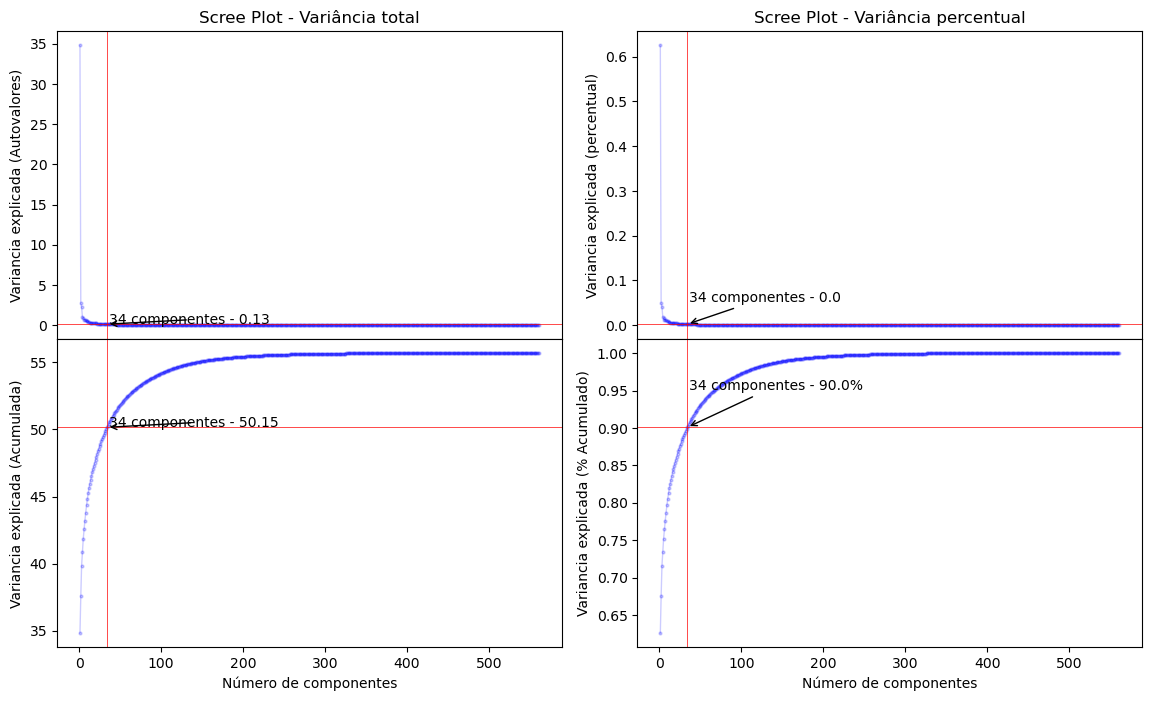

rank_ac,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
variance,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.002,0.002,0.002,0.002,0.002,0.002
variance_ac,0.879,0.882,0.885,0.888,0.891,0.894,0.897,0.900,0.903,0.905,0.907,0.909,0.911,0.913,0.915


In [19]:
# Critério 3: % variância explicada
n2=int(input('Percentual desejado para explicação da variável: '))
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

# Número de componentes pelo critério 3
varexplicada = n2/100
ncomp_criterio3 = (prcomp.explained_variance_ratio_.cumsum()<varexplicada).sum()+1


#Gráfico da variância nominal por qtd-componentes
num_componentes = np.arange(prcomp.n_components_) + 1
ax[0,0].plot(num_componentes, prcomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,0].set_title('Scree Plot - Variância total')
ax[0,0].set_xlabel('Número de componentes')
ax[0,0].set_ylabel('Variancia explicada (Autovalores)')

#Gráfico da variância nominal acumulada por qtd-componentes
ax[1,0].plot(num_componentes, prcomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,0].set_xlabel('Número de componentes')
ax[1,0].set_ylabel('Variancia explicada (Acumulada)')

#Gráfico da variância percentual por qtd-componentes
ax[0,1].plot(num_componentes, prcomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0,1].set_title('Scree Plot - Variância percentual')
ax[0,1].set_xlabel('Número de componentes')
ax[0,1].set_ylabel('Variancia explicada (percentual)')

#Gráfico da variância percentual acumulada por qtd-componentes
ax[1,1].plot(num_componentes, prcomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1,1].set_xlabel('Número de componentes')
ax[1,1].set_ylabel('Variancia explicada (% Acumulado)')

# linhas verticais de referência
ax[0,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axvline(x = ncomp_criterio3, color = 'r', linestyle = '-', linewidth=.5)

# linhas horizontais
ncomp_criterio2 = 50
ax[0,0].axhline(y = prcomp.explained_variance_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,0].axhline(y = prcomp.explained_variance_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[0,1].axhline(y = prcomp.explained_variance_ratio_[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)
ax[1,1].axhline(y = prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], color = 'r', linestyle = '-', linewidth=.5)

# Adicionando o valor da intersecção nos gráficos
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1], 2)*100}%'
ax[1,1].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_ratio_.cumsum()[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_.cumsum()[ncomp_criterio3-1], 2)}'
ax[1,0].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_.cumsum()[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_.cumsum()[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_ratio_[ncomp_criterio3-1], 2)}'
ax[0,1].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_ratio_[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_ratio_[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)
text = f'{ncomp_criterio3} componentes - {np.round(prcomp.explained_variance_[ncomp_criterio3-1], 2)}'
ax[0,0].annotate(text, xy=(ncomp_criterio3, prcomp.explained_variance_[ncomp_criterio3-1]), xytext=(ncomp_criterio3+2, prcomp.explained_variance_[ncomp_criterio3-1]+0.05),
             arrowprops=dict(facecolor='red', arrowstyle="->"), fontsize=10)

plt.show()

ratio = np.round(prcomp.explained_variance_ratio_,3)
variance_ratio = pd.DataFrame({'variance': ratio})
variance_ratio_cumsum = pd.DataFrame({'variance_ac': ratio.cumsum()})
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['variance_ac'].rank(method='min',ascending=True).astype(int)
variance_ratio_cumsum['rank_ac'] = variance_ratio_cumsum['rank_ac'].astype(str) 
variance_ratios_concat = pd.concat([variance_ratio, variance_ratio_cumsum], axis=1)
variance_ratios_concat[(ncomp_criterio3-10):(ncomp_criterio3+5)].set_index('rank_ac').T